In [2]:
import pandas as pd
import numpy as np

## Ładowanie i obróbka danych

In [3]:
gospodarstwa = pd.read_csv('gospodarstwa.csv', encoding = 'ISO-8859-1')

C:\Users\Kajetan\MEGA\Studia, prywatne\MMC\virtualenv\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (2201,2202,2462) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


hl2: Przecietny miesieczny dochód w ubieglym roku

ha1pow: POWIAT

ha1woj: WOJEWODZTWO

In [4]:
gosp = gospodarstwa[['hl2','ha1pow','ha1woj']]
gosp = gosp.dropna()
gosp.columns = ['doch', 'powi', 'woj']
gosp.woj /= 2
gosp.woj -= 1
gosp.woj = pd.to_numeric(gosp.woj, downcast='integer')
gosp.powi = pd.to_numeric(gosp.powi, downcast='integer')

In [5]:
for w in range(len(gosp.woj.unique())):
    gosp_filt_woj = gosp[gosp.woj==w]
    for p, _p in enumerate(sorted(gosp_filt_woj.powi.unique())):
        gosp.loc[(gosp.woj==w) & (gosp.powi==_p), ['powi']] = p

## Utworzenie struktury i przypisanie początkowych wartości

In [6]:
def init_sums():
    global sums
    sums = dict(
        m = 0, mu_k = 0, v2 = 0, sigma2_k = 0,
        mu_woj = np.zeros(len(mu_woj)),
        sigma2_woj = np.zeros(len(sigma2_woj)),
        mu_powi = tuple(np.zeros(len(p_in_w)) for p_in_w in mu_powi),
        sigma2_powi = tuple(np.zeros(len(p_in_w)) for p_in_w in sigma2_powi)
    )

def init_values():
    global mu_powi, sigma2_powi, mu_woj, sigma2_woj, m, mu_k, v2, sigma2_k, sums, dochody, sums_gosp_in_p, sums_gosp_in_p2
    m = mu_k = gosp.doch.mean()
    v2 = 1  # nie chcemy dać za dużej swobody, bo v2 i m przez self-reinforcement dążą do overflow
    sigma2_k = gosp.doch.var()
    mu_powi_list = []
    sigma2_powi_list = []
    mu_woj_list = []
    sigma2_woj_list = []
    for w in range(len(gosp.woj.unique())):
        gosp_filt_woj = gosp[gosp['woj']==w]
        mu_woj_list.append(gosp_filt_woj.doch.mean())
        sigma2_woj_list.append(gosp_filt_woj.doch.var())
        mu_powi_in_woj = []
        sigma2_powi_in_woj = []
        for p in range(len(gosp_filt_woj.powi.unique())):
            gosp_filt_powi = gosp_filt_woj[gosp_filt_woj.powi==p]
            mu_powi_in_woj.append(gosp_filt_powi.doch.mean())
            maybe_var = gosp_filt_powi.doch.var()
            if np.isnan(maybe_var):
                sigma2_powi_in_woj.append(0)
            else:
                sigma2_powi_in_woj.append(maybe_var)
        mu_powi_list.append(np.array(mu_powi_in_woj))
        sigma2_powi_list.append(np.array(sigma2_powi_in_woj))
    mu_woj = np.array(mu_woj_list)
    sigma2_woj = np.array(sigma2_woj_list)
    mu_powi = tuple(mu_powi_list)
    sigma2_powi = tuple(sigma2_powi_list)
    dochody = np.array([
        np.array( [np.array(gosp.loc[(gosp.woj==w) & (gosp.powi==p),['doch']]) for p in range(len(mu_powi[w]))] )
        for w in range(len(mu_woj))
    ])
    sums_gosp_in_p = np.array([
        np.array( [np.sum(dochody[w][p]) for p in range(len(mu_powi[w]))] )
        for w in range(len(mu_woj))
    ])
    sums_gosp_in_p2 = np.array([
        np.array( [np.sum(dochody[w][p]**2) for p in range(len(mu_powi[w]))] )
        for w in range(len(mu_woj))
    ])
    init_sums()

## Funkcje losujące

In [7]:
from numpy.random import normal
from numpy.random import gamma

#### Dodatkowe zmienne

$$m | ... \sim \mathcal N (\mu_k, v^2)$$

In [8]:
def draw_m(mu_k, v2):
    return normal(mu_k, np.sqrt(v2))

Tu dajemy prior $\frac{1}{(v^2)^{1.51}}$, żeby mieć całkowalność $v^2$

$$\frac{1}{v^2} | ... \sim \Gamma(1.01, \frac{2}{(m-\mu_k)^2 })$$

In [9]:
def draw_v2(m, mu_k):
    if m == mu_k:
        return 0
    return gamma( 1.01, 2/(m-mu_k)**2 )**-1

#### Średnie

$$\mu_k | ... \sim \mathcal N ( \frac{v^2 \sum_{j=1}^{W} \mu_{w_j} + \sigma_k^2 m}{v^2 W + \sigma_k^2} , \frac{v^2 \sigma_k^2}{v^2 W + \sigma_k^2} )$$

$$\mu_{w_i} | ... \sim \mathcal N ( \frac{\sigma_k^2 \sum_{j=1}^{P_{w_i}} \mu_{p_j} + \sigma_{w_i}^2 \mu_k}{\sigma_k^2 P_{w_i} + \sigma_{w_i}^2} , \frac{\sigma_k^2 \sigma_{w_i}^2}{\sigma_k^2 P_{w_i} + \sigma_{w_i}^2} )$$

$$\mu_{p_i} | ... \sim \mathcal N ( \frac{\sigma_w^2 \sum_{j=1}^{G_{p_i}} X_{g,p_i} + \sigma_{p_i}^2 \mu_w}{\sigma_w^2 G_{p_i} + \sigma_{p_i}^2} , \frac{\sigma_w^2 \sigma_{p_i}^2}{\sigma_w^2 G_{p_i} + \sigma_{p_i}^2} )$$

In [10]:
def draw_mu_general(var_hi, mus_lo, var, mu_hi):
    # var_hi: wariancja wyższego poziomu
    # mus_lo: średnie niższego poziomu
    # var: wariancja tego poziomu
    # mu_hi: wariancja wyższego poziomu
    loc = ( var_hi*np.sum(mus_lo) + var*mu_hi ) / (var_hi*len(mus_lo) + var)
    var = var_hi*var / (var_hi*len(mus_lo) + var)
    scale = np.sqrt(var)
    draw = normal(loc, scale)
    return draw

In [11]:
def draw_mu_k(v2, mu_woj, sigma2_k, m):
    return draw_mu_general(v2, mu_woj, sigma2_k, m)

def draw_mu_w(sigma2_k, mu_powi_in_w, sigma2_w, mu_k):
    return draw_mu_general(sigma2_k, mu_powi_in_w, sigma2_w, mu_k)
    
def draw_mu_p(sigma2_w, gosp_in_p, sigma2_p, mu_w):
    return draw_mu_general(sigma2_w, gosp_in_p, sigma2_p, mu_w)

#### Wariancje

$$\frac{1}{\sigma_k^2} | ... \sim \Gamma(\frac W 2, \frac{2}{\sum_{w=1}^W (\mu_w-\mu_k)^2 })$$

$$\frac{1}{\sigma_{w_i}^2} | ... \sim \Gamma(\frac{P_{w_i}}{2}, \frac{2}{\sum_{p=1}^{P_{w_i}} (\mu_{p,w_i} - \mu_{w_i})^2 })$$

$$\frac{1}{\sigma_{p_i}^2} | ... \sim \Gamma(\frac{G_{p_i}}{2} \vee 1.01, \frac{2}{\sum_{g=1}^{G_{p_i}} (X_{g,p_i}-\mu_{p_i})^2 }) \text{ (shape, scale)}$$

In [12]:
def draw_sigma2_general(mus_lo, mu):
    shape = len(mus_lo)/2
    scale = 2 / np.sum((mus_lo-mu)**2)
    return gamma(shape, scale)**-1

In [13]:
def draw_sigma2_k(mu_woj, mu_k):
    return draw_sigma2_general(mu_woj, mu_k)

def draw_sigma2_w(mu_powi_in_w, mu_w):
    return draw_sigma2_general(mu_powi_in_w, mu_w)

def draw_sigma2_p(n_of_gosp, sum_gosp_in_p2, sum_gosp_in_p, mu_p):
    shape = max(n_of_gosp/2, 1.01)
    scale = 2 / (sum_gosp_in_p2 - 2*mu_p*sum_gosp_in_p + n_of_gosp*mu_p**2)
    return gamma(shape, scale)**-1

In [14]:
import pickle

In [15]:
with open(f'dump/sums9.p', 'rb') as fp:
    sums = pickle.load(fp)

## Próbnik Gibbsa

In [19]:
n_length = 10
sum_from_n_gte = 2
nn_length = int(2*10**5)

In [40]:
init_values()
for n in range(n_length):
    if n > sum_from_n_gte:
        n_of_summands = (n - sum_from_n_gte) * nn_length
        with open(f'dump/sums{n}.p', 'wb') as fp:
            pickle.dump(sums, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Wyniki po {n*nn_length} iteracjach:")
        print(f"  m = {sums['m']/n_of_summands}\n"
              f"  v2 = {sums['v2']/n_of_summands}\n"
              f"  mu_k = {sums['mu_k']/n_of_summands}\n"
              f"  sigma2_k = {sums['sigma2_k']/n_of_summands}")
    for nn in range(nn_length):
        m = draw_m(mu_k, v2)
        v2 = draw_v2(m, mu_k)
        mu_k = draw_mu_k(v2, mu_woj, sigma2_k, m)
        sigma2_k = draw_sigma2_k(mu_woj, mu_k)
        for w in range(len(mu_woj)):
            mu_woj[w] = draw_mu_w(sigma2_k, mu_powi[w], sigma2_woj[w], mu_k)
            sigma2_woj[w] = draw_sigma2_w(mu_powi[w], mu_woj[w])
            if n >= sum_from_n_gte:
                sums['mu_woj'][w] += mu_woj[w]
                sums['sigma2_woj'][w] += sigma2_woj[w]
            for p in range(len(mu_powi[w])):
                if sigma2_powi[w][p] == 0:
                    continue
                doch_in_p = dochody[w][p]
                mu_powi[w][p] = draw_mu_p(sigma2_woj[w], doch_in_p, sigma2_powi[w][p], mu_woj[w])
                sigma2_powi[w][p] = draw_sigma2_p(len(doch_in_p), sums_gosp_in_p2[w][p], sums_gosp_in_p[w][p], mu_powi[w][p])
                if n >= sum_from_n_gte:
                    sums['mu_powi'][w][p] += mu_powi[w][p]
                    sums['sigma2_powi'][w][p] += sigma2_powi[w][p]
        if n >= sum_from_n_gte:
            sums['m'] += m
            sums['v2'] += v2
            sums['mu_k'] += mu_k
            sums['sigma2_k'] += sigma2_k

    #print(f"Wyniki po {(n+1)*nn_length} iteracjach:")
    #print(f"  m = {m}\n  v2 = {v2}\n  mu_k = {mu_k}\n  sigma2_k = {sigma2_k}")
    #print("  WOJEWÓDZTWA:")
    #for w in range(len(mu_woj)):
    #    print(f"    woj{w}: {mu_woj[w]}, {sigma2_woj[w]}")

Wyniki po 600000 iteracjach:
  m = 3475.523840392701
  v2 = 0.0
  mu_k = 3475.523840392701
  sigma2_k = 128941.37551527708
Wyniki po 800000 iteracjach:
  m = 3475.5238404100496
  v2 = 0.0
  mu_k = 3475.5238404100496
  sigma2_k = 127728.77264828623
Wyniki po 1000000 iteracjach:
  m = 3475.5238404158326
  v2 = 0.0
  mu_k = 3475.5238404158326
  sigma2_k = 128581.69926357007
Wyniki po 1200000 iteracjach:
  m = 3475.523840418724
  v2 = 0.0
  mu_k = 3475.523840418724
  sigma2_k = 127807.13468646133
Wyniki po 1400000 iteracjach:
  m = 3475.523840420459
  v2 = 0.0
  mu_k = 3475.523840420459
  sigma2_k = 127533.24041296553
Wyniki po 1600000 iteracjach:
  m = 3475.5238404216157
  v2 = 0.0
  mu_k = 3475.5238404216157
  sigma2_k = 127315.76052215192
Wyniki po 1800000 iteracjach:
  m = 3475.523840366507
  v2 = 0.0
  mu_k = 3475.523840366507
  sigma2_k = 127100.71635159398


In [23]:
import copy

In [24]:
srednie = copy.deepcopy(sums)

In [25]:
n_of_summands = (n_length - sum_from_n_gte) * nn_length

In [26]:
srednie['m'] /= n_of_summands
srednie['v2'] /= n_of_summands
srednie['mu_k'] /= n_of_summands
srednie['sigma2_k'] /= n_of_summands

In [27]:
srednie['mu_woj'] /= n_of_summands
srednie['sigma2_woj'] /= n_of_summands
for w in range(len(sums['mu_woj'])):
    for p in range(len(sums['mu_powi'][w])):
        srednie['mu_powi'][w][p] /= n_of_summands
        srednie['sigma2_powi'][w][p] /= n_of_summands

# Wyniki

Średnia i wariancja kraju:

In [28]:
srednie['mu_k'], srednie['sigma2_k']

(3041.083360320694, 111213.12680764473)

In [29]:
srednie['m'], srednie['v2']

(3041.083360320694, 0.0)

Średnie i wariancje województw:

Text(0.5, 1.0, 'Średnie dochody w województwach')

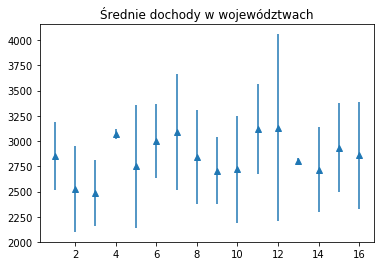

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.array(range(1, 17))
y = srednie['mu_woj']
e = np.sqrt(srednie['sigma2_woj'])

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.title("Średnie dochody w województwach")

In [31]:
init_values()

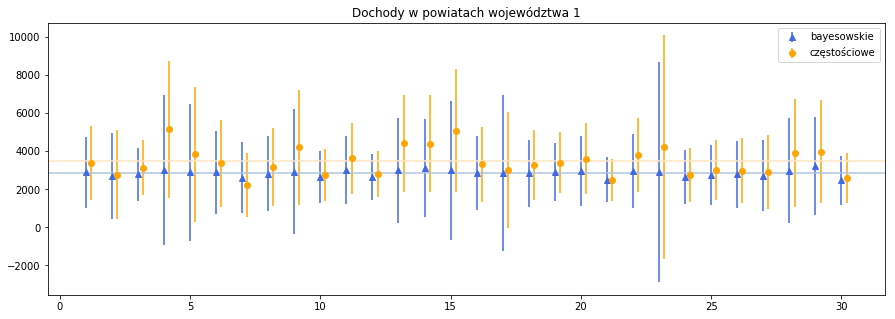

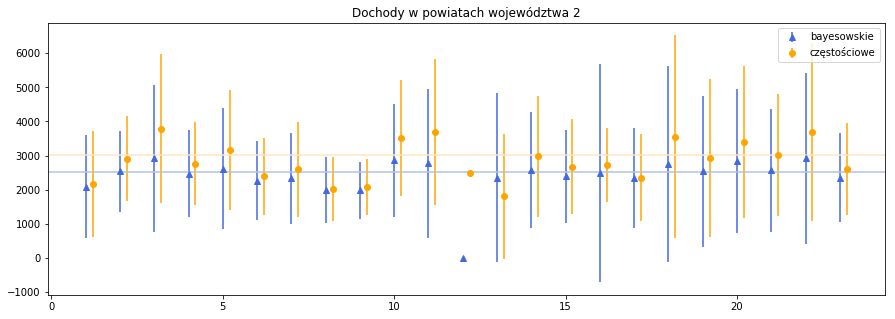

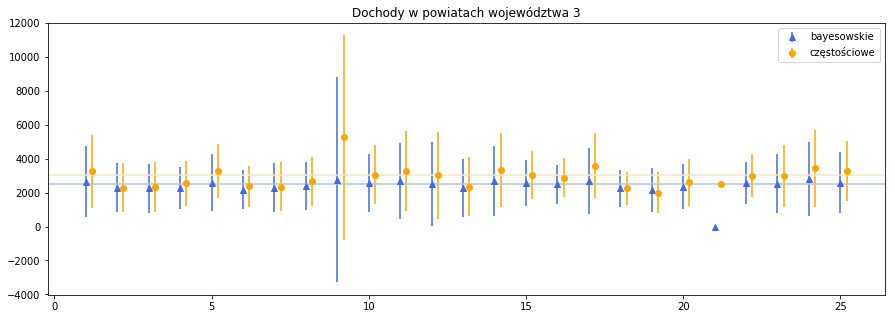

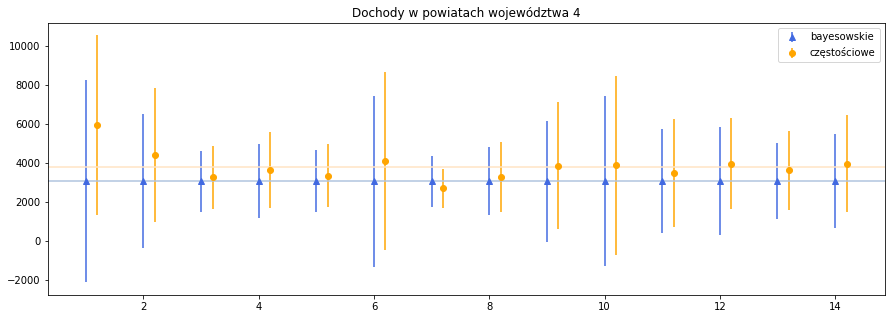

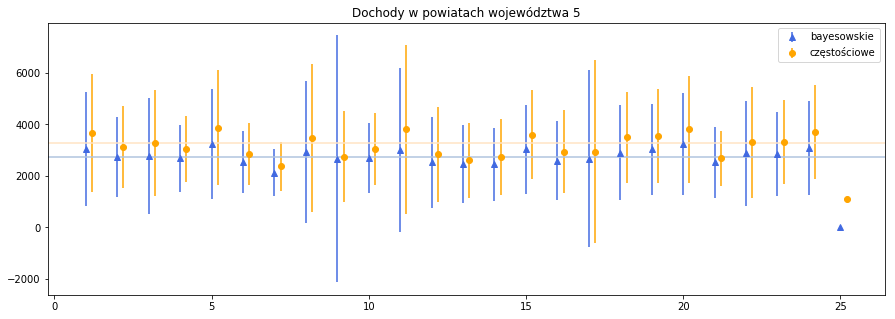

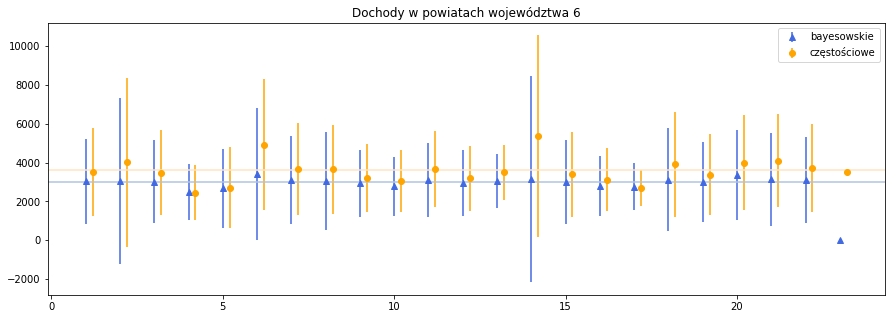

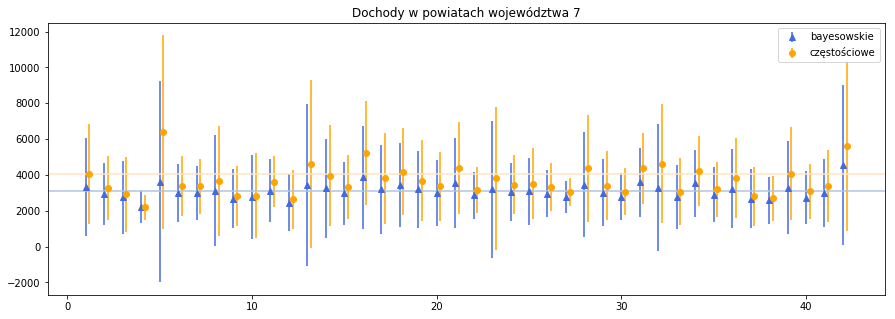

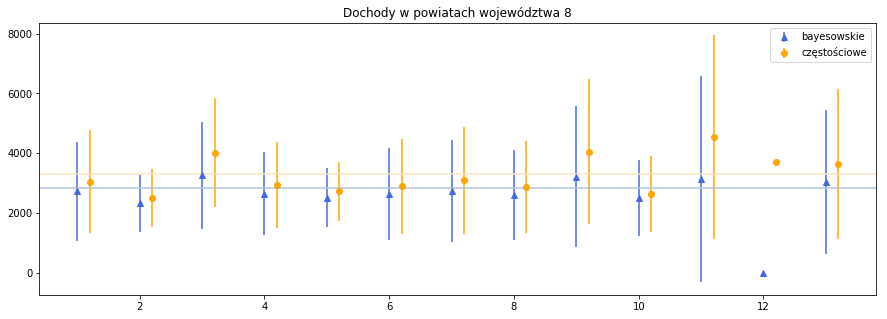

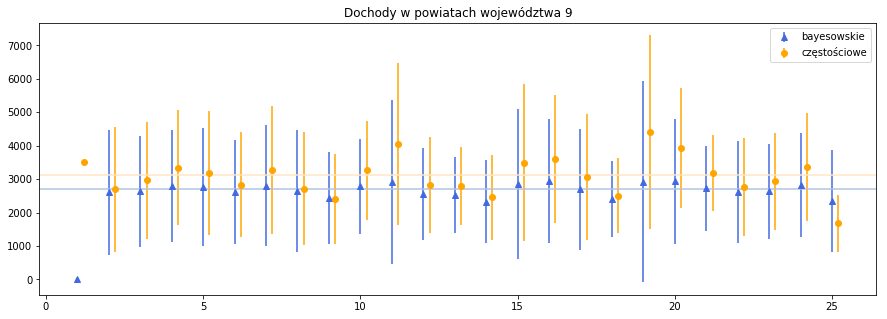

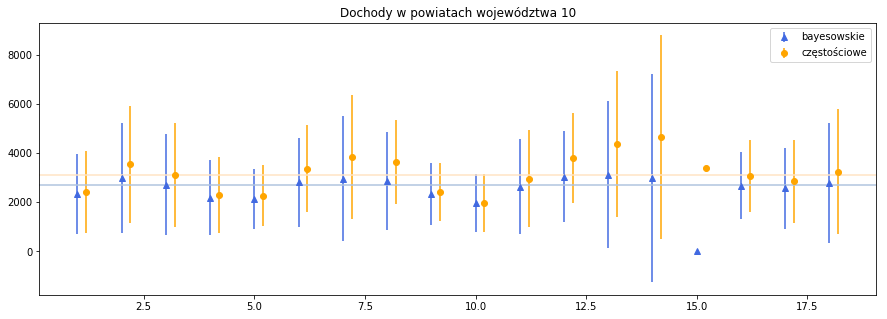

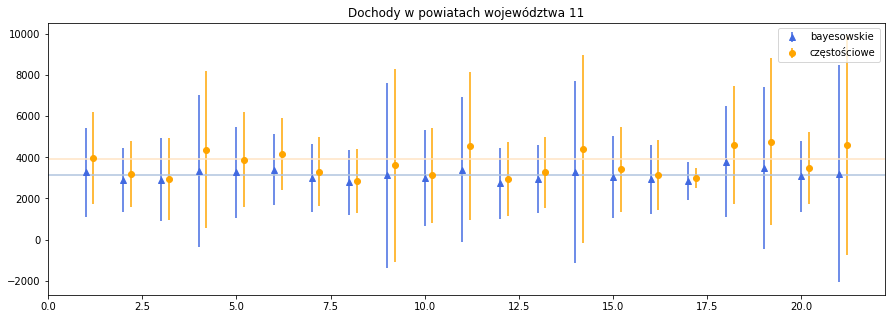

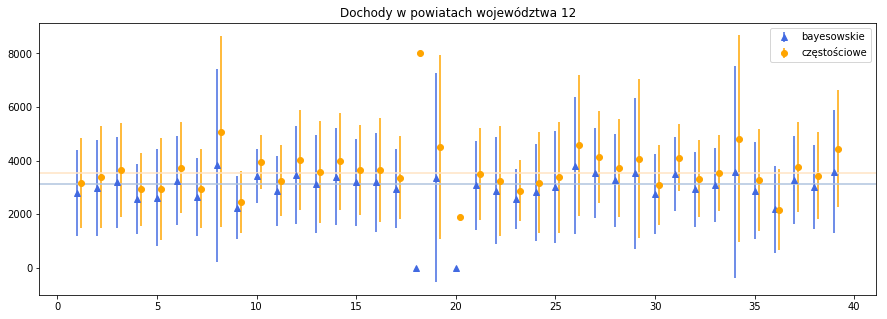

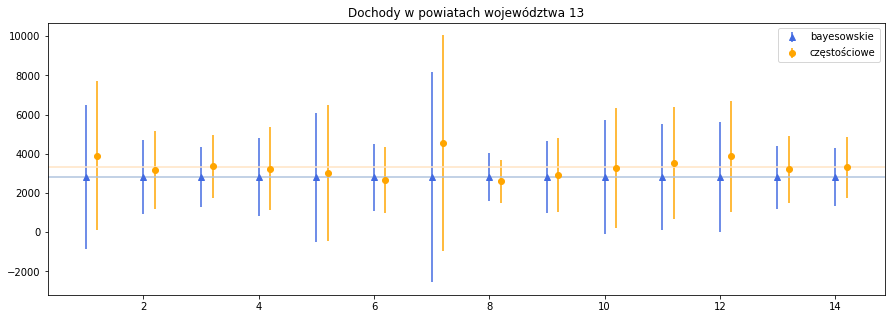

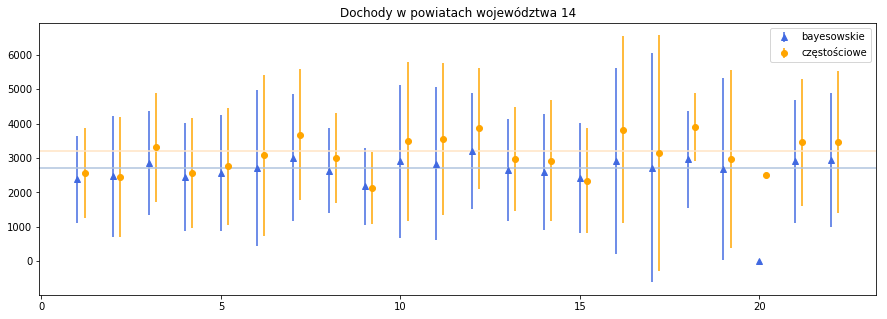

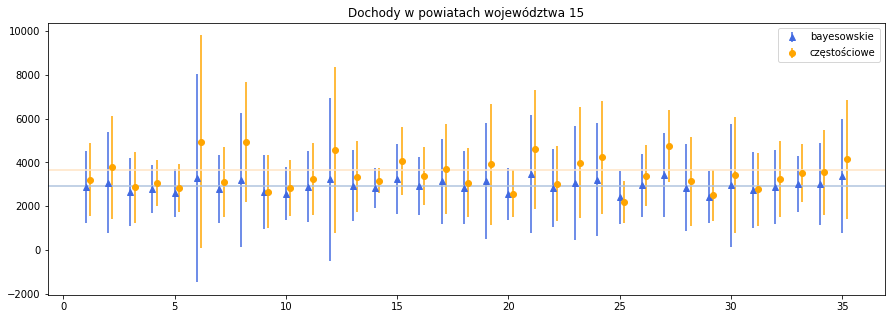

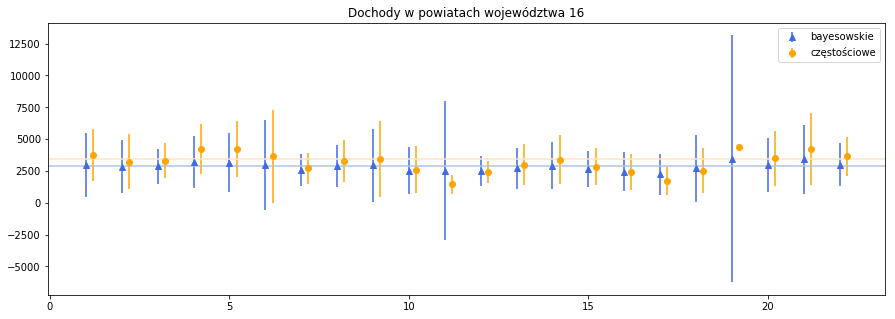

In [32]:
for w in range(len(mu_woj)):
    plt.figure(figsize=(15,5))
    plt.axhline(srednie['mu_woj'][w], color="lightsteelblue")
    plt.axhline(mu_woj[w], color="bisque")
    x1 = np.array(range(1, len(mu_powi[w])+1))
    y1 = srednie['mu_powi'][w]
    e1 = np.sqrt(srednie['sigma2_powi'][w])
    czest = plt.errorbar(x1, y1, e1, linestyle='None', marker='^', label="bayesowskie", color="royalblue")
    x2 = np.array(range(1, len(mu_powi[w])+1))+0.2
    y2 = mu_powi[w]
    e2 = np.sqrt(sigma2_powi[w])
    bayes = plt.errorbar(x2, y2, e2, linestyle='None', marker='o', label="częstościowe", color="orange")

    plt.legend(handles=[czest, bayes])
    plt.title(f"Dochody w powiatach województwa {w+1}")
    plt.show()